<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
    
<h1 style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:150%"><b> Table of contents </b></h1>

 - [**Introduction**](#1)

 - [**Explore**](#2)
 
 - [**Pre-processing and feature selection**](#3)
    
 - [**Modelling and Evaluation**](#4)
    - [**kNN**](#4_1)
    - [**SVM**](#4_2)
    - [**Random Forest**](#4_3)
    - [**LSTM**](#4_4)
    
 - [**Evaluate**](#5)
 - [**Conclusion**](#6)
   

<a id='1'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Introduction</b>

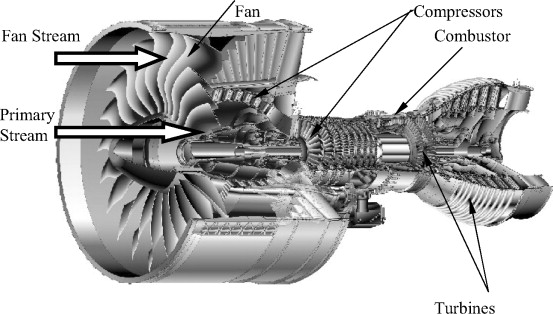

Description
Prognostics and health management is an important topic in industry for predicting state of assets to avoid downtime and failures. This data set is the Kaggle version of the very well known public data set for asset degradation modeling from NASA. It includes Run-to-Failure simulated data from turbo fan jet engines.

Engine degradation simulation was carried out using C-MAPSS. Four different were sets simulated under different combinations of operational conditions and fault modes. Records several sensor channels to characterize fault evolution. The data set was provided by the Prognostics CoE at NASA Ames.

Prediction Goal
In this dataset the goal is to predict the remaining useful life (RUL) of each engine in the test dataset. RUL is equivalent of number of flights remained for the engine after the last datapoint in the test dataset.

Experimental Scenario
Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:
1) unit number

2) time, in cycles

3) operational setting 1

4) operational setting 2

5) operational setting 3

6) sensor measurement 1

7) sensor measurement 2

…

26) sensor measurement 26


Data Set Organization

**Data Set: FD001**
 - Train trjectories: 100
 - Test trajectories: 100
 - Conditions: ONE (Sea Level)
 - Fault Modes: ONE (HPC Degradation)

**Data Set: FD002**
 - Train trjectories: 260
 - Test trajectories: 259
 - Conditions: SIX
 - Fault Modes: ONE (HPC Degradation)

**Data Set: FD003**
 - Train trjectories: 100
 - Test trajectories: 100
 - Conditions: ONE (Sea Level)
 - Fault Modes: TWO (HPC Degradation, Fan Degradation)

**Data Set: FD004**
 - Train trjectories: 248
 - Test trajectories: 249
 - Conditions: SIX
 - Fault Modes: TWO (HPC Degradation, Fan Degradation)

Reference
Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

Alternatively the dataset can be downloaded from https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

<a id='2'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Explore</b>

In [37]:
# Import the libraries required for exploration and preproccesing
import numpy as np
import pandas as pd

from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio


import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings

# Configure Jupyter Notebook
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)
# pd.set_option('max_colwidth', -1)
display(HTML("<style>div.output_scroll { height: 35em; }</style>"))

reload(plt)
%matplotlib inline
%config InlineBackend.figure_format ='retina'

warnings.filterwarnings('ignore')

# configure plotly graph objects
pio.renderers.default = 'iframe'
# pio.renderers.default = 'vscode'

pio.templates["ck_template"] = go.layout.Template(
    layout_colorway = px.colors.sequential.Viridis, 
#     layout_hovermode = 'closest',
#     layout_hoverdistance = -1,
    layout_autosize=False,
    layout_width=800,
    layout_height=600,
    layout_font = dict(family="Calibri Light"),
    layout_title_font = dict(family="Calibri"),
    layout_hoverlabel_font = dict(family="Calibri Light"),
#     plot_bgcolor="white",
)
 
# pio.templates.default = 'seaborn+ck_template+gridon'
pio.templates.default = 'ck_template+gridon'
# pio.templates.default = 'seaborn+gridon'
# pio.templates

In [38]:
# Give names to the features
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
col_names = index_names + setting_names + sensor_names

# df_train = pd.read_csv(('./CMaps/train_FD001.txt'), sep='\s+', header=None, names=col_names)
# df_test = pd.read_csv(('./CMaps/test_FD001.txt'), sep='\s+', header=None, names=col_names)
# df_test_RUL = pd.read_csv(('./CMaps/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

df_train = pd.read_csv(('train_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test = pd.read_csv(('test_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test_RUL = pd.read_csv(('RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

First up is just to eyeball the data.

The training data set has data up to the point of failure, therefore the maximum cycle for each engine was the life that was achieved by the engine.

In the training set, the data has not yet reached the point of failure, therefore the RUL file will tell us how much time still remained until failure. We'll form our predictions against this value

In [39]:
df_train.head()

engine  cycle  setting_1  setting_2  setting_3  (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  (Fan inlet Pressure) (psia)  (bypass-duct pressure) (psia)  (HPC outlet pressure) (psia)  (Physical fan speed) (rpm)  (Physical core speed) (rpm)  (Engine pressure ratio(P50/P2)  (HPC outlet Static pressure) (psia)  (Ratio of fuel flow to Ps30) (pps/psia)  (Corrected fan speed) (rpm)  (Corrected core speed) (rpm)  (Bypass Ratio)   (Burner fuel-air ratio)  (Bleed Enthalpy)  (Required fan speed)  (Required fan conversion speed)  (High-pressure turbines Cool air flow)  (Low-pressure turbines Cool air flow)
0       1      1    -0.0007    -0.0004      100.0                        518.67                         641.82                        1589.70                        1400.60                        14.62                          21.61                        554.36                     2388.06                      9046.19                             1.3                                47.47                                   521.66                      2388.02                       8138.62           8.4195                     0.03               392                  2388                            100.0                                   39.06                                23.4190
1       1      2     0.0019    -0.0003      100.0                        518.67                         642.15                        1591.82                        1403.14                        14.62                          21.61                        553.75                     2388.04                      9044.07                             1.3                                47.49                                   522.28                      2388.07                       8131.49           8.4318                     0.03               392                  2388                            100.0                                   39.00                                23.4236
2       1      3    -0.0043     0.0003      100.0                        518.67                         642.35                        1587.99                        1404.20                        14.62                          21.61                        554.26                     2388.08                      9052.94                             1.3                                47.27                                   522.42                      2388.03                       8133.23           8.4178                     0.03               390                  2388                            100.0                                   38.95                                23.3442
3       1      4     0.0007     0.0000      100.0                        518.67                         642.35                        1582.79                        1401.87                        14.62                          21.61                        554.45                     2388.11                      9049.48                             1.3                                47.13                                   522.86                      2388.08                       8133.83           8.3682                     0.03               392                  2388                            100.0                                   38.88                                23.3739
4       1      5    -0.0019    -0.0002      100.0                        518.67                         642.37                        1582.85                        1406.22                        14.62                          21.61                        554.00                     2388.06                      9055.15                             1.3                                47.28                                   522.19                      2388.04                       8133.80           8.4294                     0.03               393                  2388                  

In [40]:
df_test.head()

engine  cycle  setting_1  setting_2  setting_3  (Fan inlet temperature) (◦R)  (LPC outlet temperature) (◦R)  (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  (Fan inlet Pressure) (psia)  (bypass-duct pressure) (psia)  (HPC outlet pressure) (psia)  (Physical fan speed) (rpm)  (Physical core speed) (rpm)  (Engine pressure ratio(P50/P2)  (HPC outlet Static pressure) (psia)  (Ratio of fuel flow to Ps30) (pps/psia)  (Corrected fan speed) (rpm)  (Corrected core speed) (rpm)  (Bypass Ratio)   (Burner fuel-air ratio)  (Bleed Enthalpy)  (Required fan speed)  (Required fan conversion speed)  (High-pressure turbines Cool air flow)  (Low-pressure turbines Cool air flow)
0       1      1     0.0023     0.0003      100.0                        518.67                         643.02                        1585.29                        1398.21                        14.62                          21.61                        553.90                     2388.04                      9050.17                             1.3                                47.20                                   521.72                      2388.03                       8125.55           8.4052                     0.03               392                  2388                            100.0                                   38.86                                23.3735
1       1      2    -0.0027    -0.0003      100.0                        518.67                         641.71                        1588.45                        1395.42                        14.62                          21.61                        554.85                     2388.01                      9054.42                             1.3                                47.50                                   522.16                      2388.06                       8139.62           8.3803                     0.03               393                  2388                            100.0                                   39.02                                23.3916
2       1      3     0.0003     0.0001      100.0                        518.67                         642.46                        1586.94                        1401.34                        14.62                          21.61                        554.11                     2388.05                      9056.96                             1.3                                47.50                                   521.97                      2388.03                       8130.10           8.4441                     0.03               393                  2388                            100.0                                   39.08                                23.4166
3       1      4     0.0042     0.0000      100.0                        518.67                         642.44                        1584.12                        1406.42                        14.62                          21.61                        554.07                     2388.03                      9045.29                             1.3                                47.28                                   521.38                      2388.05                       8132.90           8.3917                     0.03               391                  2388                            100.0                                   39.00                                23.3737
4       1      5     0.0014     0.0000      100.0                        518.67                         642.51                        1587.19                        1401.92                        14.62                          21.61                        554.16                     2388.01                      9044.55                             1.3                                47.31                                   522.15                      2388.03                       8129.54           8.4031                     0.03               390                  2388                  

In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   engine                                   20631 non-null  int64  
 1   cycle                                    20631 non-null  int64  
 2   setting_1                                20631 non-null  float64
 3   setting_2                                20631 non-null  float64
 4   setting_3                                20631 non-null  float64
 5   (Fan inlet temperature) (◦R)             20631 non-null  float64
 6   (LPC outlet temperature) (◦R)            20631 non-null  float64
 7   (HPC outlet temperature) (◦R)            20631 non-null  float64
 8   (LPT outlet temperature) (◦R)            20631 non-null  float64
 9   (Fan inlet Pressure) (psia)              20631 non-null  float64
 10  (bypass-duct pressure) (psia)            20631

In [42]:
df_train.describe(include='all').T

count         mean           std        min        25%        50%        75%        max
engine                                   20631.0    51.506568  2.922763e+01     1.0000    26.0000    52.0000    77.0000   100.0000
cycle                                    20631.0   108.807862  6.888099e+01     1.0000    52.0000   104.0000   156.0000   362.0000
setting_1                                20631.0    -0.000009  2.187313e-03    -0.0087    -0.0015     0.0000     0.0015     0.0087
setting_2                                20631.0     0.000002  2.930621e-04    -0.0006    -0.0002     0.0000     0.0003     0.0006
setting_3                                20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   100.0000   100.0000
(Fan inlet temperature) (◦R)             20631.0   518.670000  0.000000e+00   518.6700   518.6700   518.6700   518.6700   518.6700
(LPC outlet temperature) (◦R)            20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   643.0000   644.5300
(HPC outlet temperature) (◦R)            20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000  1594.3800  1616.9100
(LPT outlet temperature) (◦R)            20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400  1414.5550  1441.4900
(Fan inlet Pressure) (psia)              20631.0    14.620000  1.776400e-15    14.6200    14.6200    14.6200    14.6200    14.6200
(bypass-duct pressure) (psia)            20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100    21.6100    21.6100
(HPC outlet pressure) (psia)             20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   554.0100   556.0600
(Physical fan speed) (rpm)               20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900  2388.1400  2388.5600
(Physical core speed) (rpm)              20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600  9069.4200  9244.5900
(Engine pressure ratio(P50/P2)           20631.0     1.300000  0.000000e+00     1.3000     1.3000     1.3000     1.3000     1.3000
(HPC outlet Static pressure) (psia)      20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100    47.7000    48.5300
(Ratio of fuel flow to Ps30) (pps/psia)  20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   521.9500   523.3800
(Corrected fan speed) (rpm)              20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900  2388.1400  2388.5600
(Corrected core speed) (rpm)             20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400  8148.3100  8293.7200
(Bypass Ratio)                           20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389     8.4656     8.5848
(Burner fuel-air ratio)                  20631.0     0.030000  1.387812e-17     0.0300     0.0300     0.0300     0.0300     0.0300
(Bleed Enthalpy)                         20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   394.0000   400.0000
(Required fan speed)                     20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000  2388.0000  2388.0000
(Required fan conversion speed)          20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   100.0000   100.0000
(High-pressure turbines Cool air flow)   20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300    38.9500    39.4300
(Low-pressure turbines Cool air flow)    20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979    23.3668    23.6184

We find the correlations for the features

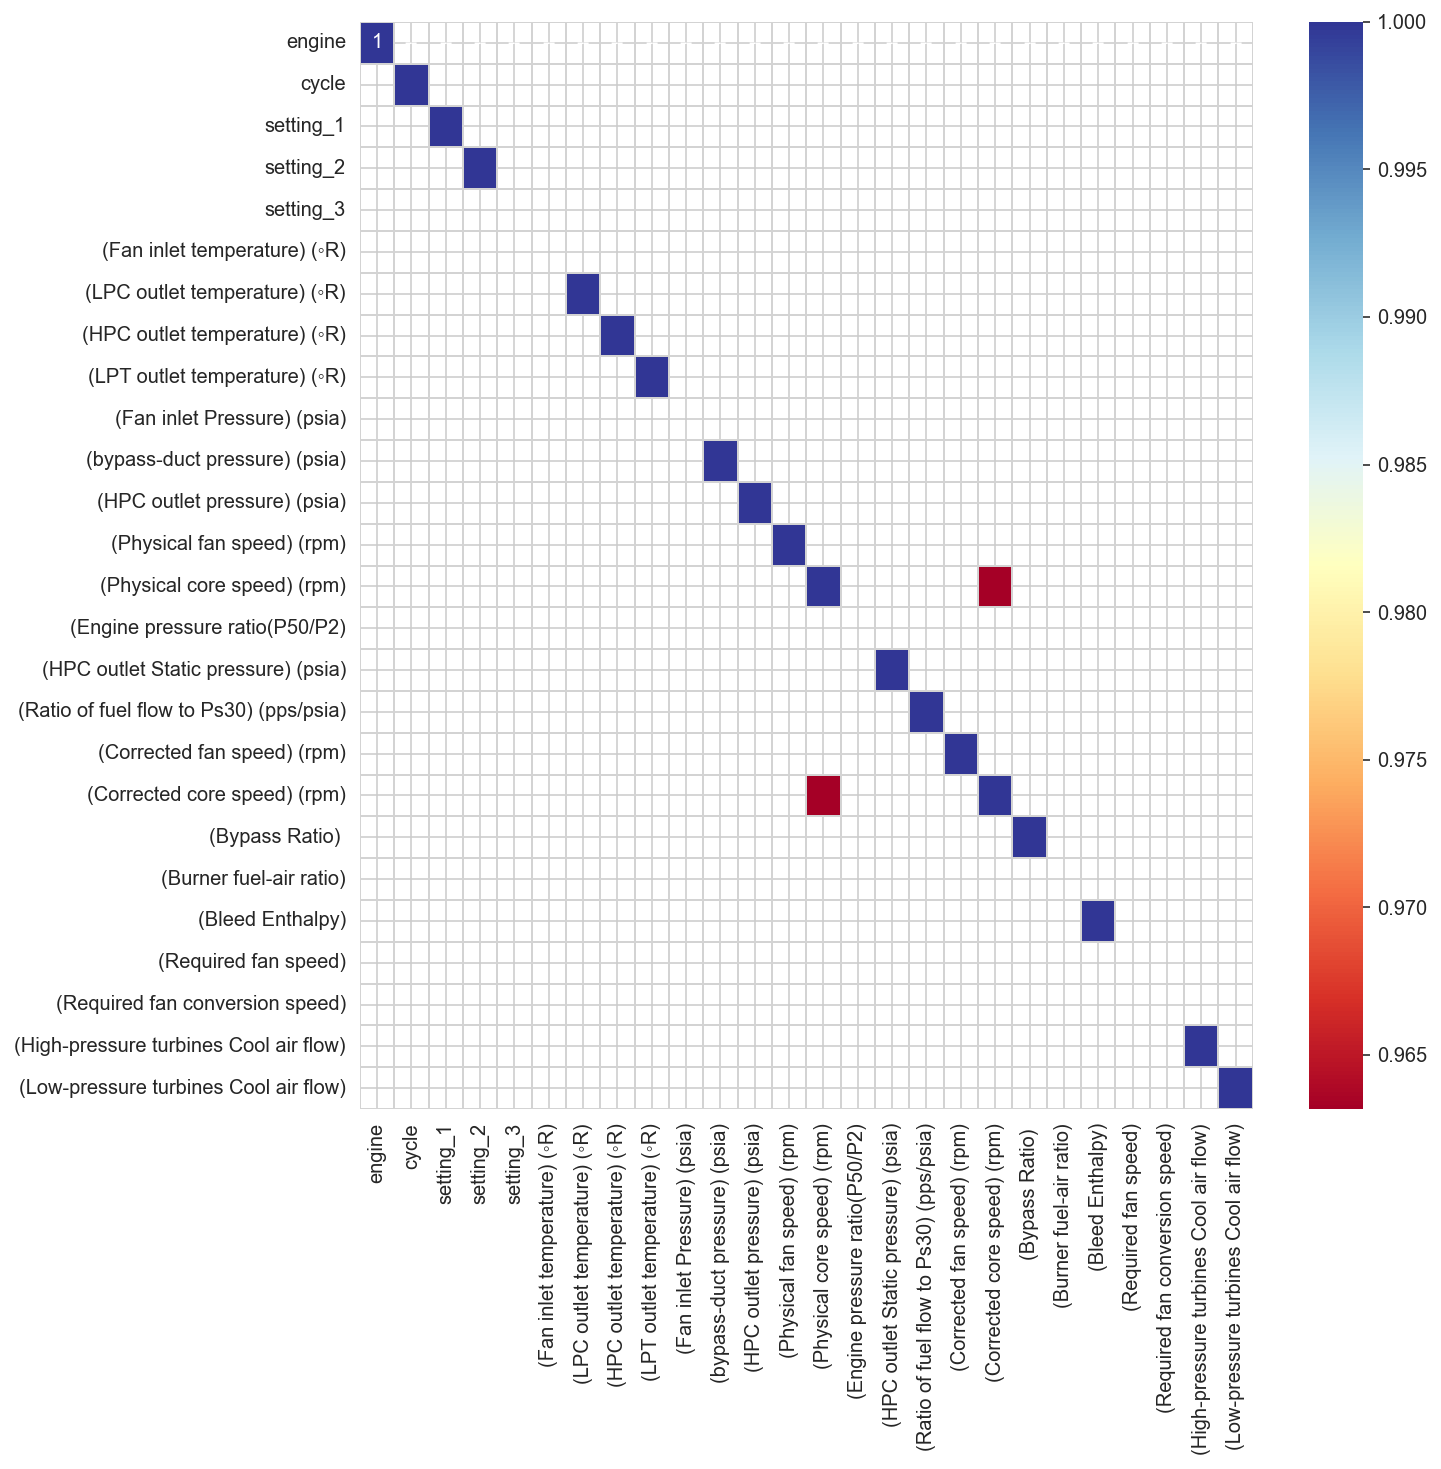

In [43]:
plt.figure(figsize=(10,10))
threshold = 0.90
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df_train.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2, 
            linecolor='lightgrey').set_facecolor('white')

In [44]:
from pandas_profiling import ProfileReport

The profiling report follows to look for outliers, missing values, and distributions. We can see that the data is imbalanced. 

In [45]:
# %%time
# profile = ProfileReport(df_train,
#                         title="Predictive Maintenance",
#                         dataset={"description": "This profiling report was generated for Carl Kirstein",
#                                  "copyright_holder": "Carl Kirstein",
#                                  "copyright_year": "2022",
#                                 },
#                         explorative=True,
#                        )
# profile

sensors with constant values can be dropped as they have no predictive power

In [46]:
# drop the sensors wiith constant values
sens_const_values = []
for feature in list(setting_names + sensor_names):
    try:
        if df_train[feature].min()==df_train[feature].max():
            sens_const_values.append(feature)
    except:
        pass

print(sens_const_values)
df_train.drop(sens_const_values,axis=1,inplace=True)
df_test.drop(sens_const_values,axis=1,inplace=True)

['setting_3', '(Fan inlet temperature) (◦R)', '(Fan inlet Pressure) (psia)', '(Engine pressure ratio(P50/P2)', '(Burner fuel-air ratio)', '(Required fan speed)', '(Required fan conversion speed)']


Drop one of the highly correlated features and keep the other. The threshold for correlation is set at 0.95

In [47]:


cor_matrix = df_train.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(corr_features)
df_train.drop(corr_features,axis=1,inplace=True)
df_test.drop(corr_features,axis=1,inplace=True)

['(Corrected core speed) (rpm)']


The remaining features

In [48]:
list(df_train)

['engine',
 'cycle',
 'setting_1',
 'setting_2',
 '(LPC outlet temperature) (◦R)',
 '(HPC outlet temperature) (◦R)',
 '(LPT outlet temperature) (◦R)',
 '(bypass-duct pressure) (psia)',
 '(HPC outlet pressure) (psia)',
 '(Physical fan speed) (rpm)',
 '(Physical core speed) (rpm)',
 '(HPC outlet Static pressure) (psia)',
 '(Ratio of fuel flow to Ps30) (pps/psia)',
 '(Corrected fan speed) (rpm)',
 '(Bypass Ratio) ',
 '(Bleed Enthalpy)',
 '(High-pressure turbines Cool air flow)',
 '(Low-pressure turbines Cool air flow)']

In [49]:
df_train.head()

engine  cycle  setting_1  setting_2  (LPC outlet temperature) (◦R)  (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  (bypass-duct pressure) (psia)  (HPC outlet pressure) (psia)  (Physical fan speed) (rpm)  (Physical core speed) (rpm)  (HPC outlet Static pressure) (psia)  (Ratio of fuel flow to Ps30) (pps/psia)  (Corrected fan speed) (rpm)  (Bypass Ratio)   (Bleed Enthalpy)  (High-pressure turbines Cool air flow)  (Low-pressure turbines Cool air flow)
0       1      1    -0.0007    -0.0004                         641.82                        1589.70                        1400.60                          21.61                        554.36                     2388.06                      9046.19                                47.47                                   521.66                      2388.02           8.4195               392                                   39.06                                23.4190
1       1      2     0.0019    -0.0003                         642.15                        1591.82                        1403.14                          21.61                        553.75                     2388.04                      9044.07                                47.49                                   522.28                      2388.07           8.4318               392                                   39.00                                23.4236
2       1      3    -0.0043     0.0003                         642.35                        1587.99                        1404.20                          21.61                        554.26                     2388.08                      9052.94                                47.27                                   522.42                      2388.03           8.4178               390                                   38.95                                23.3442
3       1      4     0.0007     0.0000                         642.35                        1582.79                        1401.87                          21.61                        554.45                     2388.11                      9049.48                                47.13                                   522.86                      2388.08           8.3682               392                                   38.88                                23.3739
4       1      5    -0.0019    -0.0002                         642.37                        1582.85                        1406.22                          21.61                        554.00                     2388.06                      9055.15                                47.28                                   522.19                      2388.04           8.4294               393                                   38.90                                23.4044

In [50]:
features = list(df_train.columns)

In [51]:
# check for missing data
for feature in features:
    print(feature + " - " + str(len(df_train[df_train[feature].isna()])))

engine - 0
cycle - 0
setting_1 - 0
setting_2 - 0
(LPC outlet temperature) (◦R) - 0
(HPC outlet temperature) (◦R) - 0
(LPT outlet temperature) (◦R) - 0
(bypass-duct pressure) (psia) - 0
(HPC outlet pressure) (psia) - 0
(Physical fan speed) (rpm) - 0
(Physical core speed) (rpm) - 0
(HPC outlet Static pressure) (psia) - 0
(Ratio of fuel flow to Ps30) (pps/psia) - 0
(Corrected fan speed) (rpm) - 0
(Bypass Ratio)  - 0
(Bleed Enthalpy) - 0
(High-pressure turbines Cool air flow) - 0
(Low-pressure turbines Cool air flow) - 0


Add the RUL as a target feature to the data

In [52]:
# define the maximum life of each engine, as this could be used to obtain the RUL at each point in time of the engine's life 
df_train_RUL = df_train.groupby(['engine']).agg({'cycle':'max'})
df_train_RUL.rename(columns={'cycle':'life'},inplace=True)
df_train_RUL.head()

life
engine      
1        192
2        287
3        179
4        189
5        269

In [53]:
df_train=df_train.merge(df_train_RUL,how='left',on=['engine'])

In [54]:
df_train['RUL']=df_train['life']-df_train['cycle']
df_train.drop(['life'],axis=1,inplace=True)

# the RUL prediction is only useful nearer to the end of the engine's life, therefore we put an upper limit on the RUL
# this is a bit sneaky, since it supposes that the test set has RULs of less than this value, the closer you are
# to the true value, the more accurate the model will be
df_train['RUL'][df_train['RUL']>125]=125
df_train.head()

engine  cycle  setting_1  setting_2  (LPC outlet temperature) (◦R)  (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  (bypass-duct pressure) (psia)  (HPC outlet pressure) (psia)  (Physical fan speed) (rpm)  (Physical core speed) (rpm)  (HPC outlet Static pressure) (psia)  (Ratio of fuel flow to Ps30) (pps/psia)  (Corrected fan speed) (rpm)  (Bypass Ratio)   (Bleed Enthalpy)  (High-pressure turbines Cool air flow)  (Low-pressure turbines Cool air flow)  RUL
0       1      1    -0.0007    -0.0004                         641.82                        1589.70                        1400.60                          21.61                        554.36                     2388.06                      9046.19                                47.47                                   521.66                      2388.02           8.4195               392                                   39.06                                23.4190  125
1       1      2     0.0019    -0.0003                         642.15                        1591.82                        1403.14                          21.61                        553.75                     2388.04                      9044.07                                47.49                                   522.28                      2388.07           8.4318               392                                   39.00                                23.4236  125
2       1      3    -0.0043     0.0003                         642.35                        1587.99                        1404.20                          21.61                        554.26                     2388.08                      9052.94                                47.27                                   522.42                      2388.03           8.4178               390                                   38.95                                23.3442  125
3       1      4     0.0007     0.0000                         642.35                        1582.79                        1401.87                          21.61                        554.45                     2388.11                      9049.48                                47.13                                   522.86                      2388.08           8.3682               392                                   38.88                                23.3739  125
4       1      5    -0.0019    -0.0002                         642.37                        1582.85                        1406.22                          21.61                        554.00                     2388.06                      9055.15                                47.28                                   522.19                      2388.04           8.4294               393                                   38.90                                23.4044  125

plot the sensor outputs for all sensors

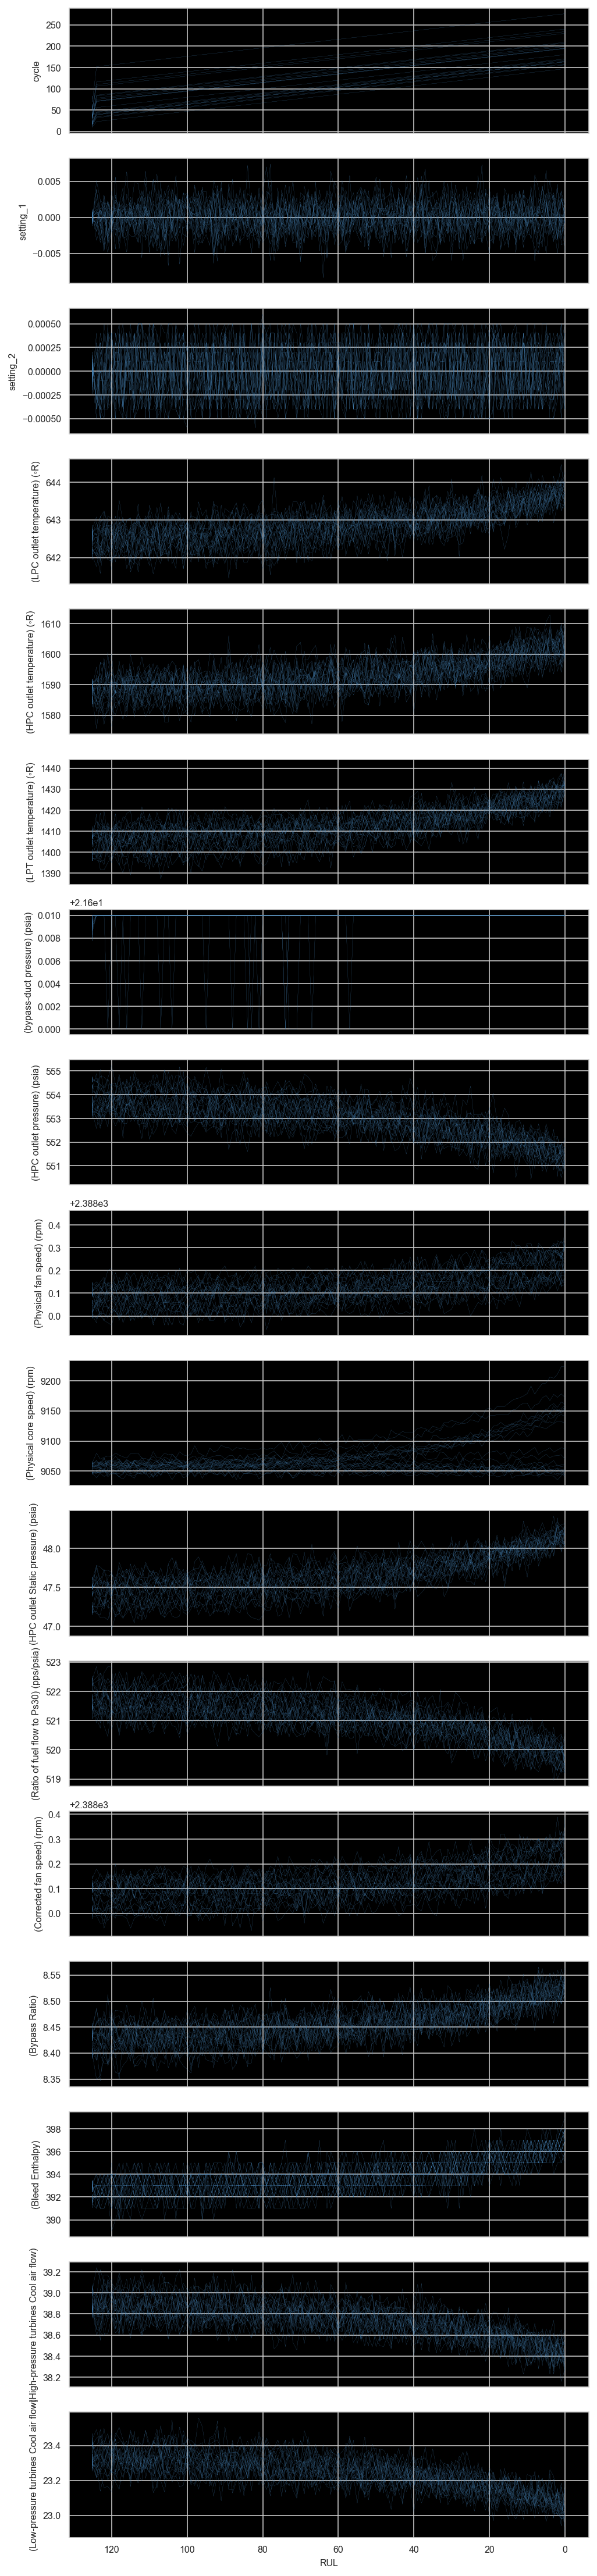

In [55]:

plt.rcParams['figure.figsize']=8,40 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 8
plt.rcParams['lines.linewidth'] = 0.1
plot_items = list(df_train.columns)[1:-1]
fig,ax = plt.subplots(len(plot_items),sharex=True)
ax[0].invert_xaxis()

engines = list(df_train['engine'].unique())

for engine in engines[10:30]:
    for i,item in enumerate(plot_items):
        f = sns.lineplot(data=df_train[df_train['engine']==engine],x='RUL',y=item,color='steelblue',ax=ax[i],
                        )

Although there are nice trends, the signals are quite noisy, therefore they could be smoothed. It is suprising that the noise carries a lot of information, and smoothing the results reduces the accuracy. The smoothing is therefore not implemented. 

In [56]:
from scipy import signal
def smooth_function(x,window=15,order=3):
    return signal.savgol_filter(x,window,order)


In [57]:
# for engine in engines:
#     for item in sensor_names:
#         try:
#             df_train[item][df_train['engine']==engine]=smooth_function(df_train[item][df_train['engine']==engine])
#             df_test[item][df_test['engine']==engine]=smooth_function(df_test[item][df_test['engine']==engine])
#         except:
#             pass

In [58]:
# plt.style.use('seaborn-white') 
# plt.rcParams['figure.figsize']=8,40 
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.size'] = 8
# plt.rcParams['lines.linewidth'] = 0.1
# plot_items = list(df_train.columns)[1:-1]
# fig,ax = plt.subplots(len(plot_items),sharex=True)
# ax[0].invert_xaxis()
# for engine in engines:
#     for i,item in enumerate(plot_items):
#         f = sns.lineplot(data=df_train[df_train['engine']==engine],x='RUL',y=item,color='steelblue',ax=ax[i],
#                         )

<a id='3'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Pre-processing and Feature Selection</b>

Perform a statistical univariate test to determine the best features.

In [59]:
# awesome bit of code from https://www.kaggle.com/code/adibouayjan/house-price-step-by-step-modeling

Selected_Features = []
import statsmodels.api as sm

def backward_regression(X, y, initial_list=[], threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression 

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling 
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


# Application of the backward regression function on our training data
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1]
backward_regression(X, y)

worst_feature : setting_1, 0.35908545988068263 
worst_feature : setting_2, 0.18806323573830117 

Selected Features:
['cycle', '(LPC outlet temperature) (◦R)', '(HPC outlet temperature) (◦R)', '(LPT outlet temperature) (◦R)', '(bypass-duct pressure) (psia)', '(HPC outlet pressure) (psia)', '(Physical fan speed) (rpm)', '(Physical core speed) (rpm)', '(HPC outlet Static pressure) (psia)', '(Ratio of fuel flow to Ps30) (pps/psia)', '(Corrected fan speed) (rpm)', '(Bypass Ratio) ', '(Bleed Enthalpy)', '(High-pressure turbines Cool air flow)', '(Low-pressure turbines Cool air flow)']


In [60]:
Selected_Features

[['cycle',
  '(LPC outlet temperature) (◦R)',
  '(HPC outlet temperature) (◦R)',
  '(LPT outlet temperature) (◦R)',
  '(bypass-duct pressure) (psia)',
  '(HPC outlet pressure) (psia)',
  '(Physical fan speed) (rpm)',
  '(Physical core speed) (rpm)',
  '(HPC outlet Static pressure) (psia)',
  '(Ratio of fuel flow to Ps30) (pps/psia)',
  '(Corrected fan speed) (rpm)',
  '(Bypass Ratio) ',
  '(Bleed Enthalpy)',
  '(High-pressure turbines Cool air flow)',
  '(Low-pressure turbines Cool air flow)']]

In [61]:
# X.head()
feature_names = Selected_Features[0]
np.shape(X)

(20631, 17)

In [62]:
len(feature_names)

15

<a id='4'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Modelling and Evaluation</b>

In [63]:
import time
model_performance = pd.DataFrame(columns=['r-Squared','RMSE','total time'])

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, accuracy_score

import sklearn
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.ensemble import RandomForestRegressor

model_performance = pd.DataFrame(columns=['R2','RMSE', 'time to train','time to predict','total time'])


def R_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

In [64]:
df_test_cycle = df_test.groupby(['engine']).agg({'cycle':'max'})
df_test_cycle.rename(columns={'cycle':'life'},inplace=True)
df_test_max = df_test.merge(df_test_cycle,how='left',on=['engine'])
df_test_max = df_test_max[(df_test_max['cycle']==df_test_max['life'])]
df_test_max.drop(['life'],axis=1,inplace=True)
# df_test_max

In [65]:
X_train = df_train[feature_names]
y_train = df_train.iloc[:,-1]
X_test = df_test_max[feature_names]
y_test = df_test_RUL.iloc[:,-1]

In [66]:
X_train.head()

cycle  (LPC outlet temperature) (◦R)  (HPC outlet temperature) (◦R)  (LPT outlet temperature) (◦R)  (bypass-duct pressure) (psia)  (HPC outlet pressure) (psia)  (Physical fan speed) (rpm)  (Physical core speed) (rpm)  (HPC outlet Static pressure) (psia)  (Ratio of fuel flow to Ps30) (pps/psia)  (Corrected fan speed) (rpm)  (Bypass Ratio)   (Bleed Enthalpy)  (High-pressure turbines Cool air flow)  (Low-pressure turbines Cool air flow)
0      1                         641.82                        1589.70                        1400.60                          21.61                        554.36                     2388.06                      9046.19                                47.47                                   521.66                      2388.02           8.4195               392                                   39.06                                23.4190
1      2                         642.15                        1591.82                        1403.14                          21.61                        553.75                     2388.04                      9044.07                                47.49                                   522.28                      2388.07           8.4318               392                                   39.00                                23.4236
2      3                         642.35                        1587.99                        1404.20                          21.61                        554.26                     2388.08                      9052.94                                47.27                                   522.42                      2388.03           8.4178               390                                   38.95                                23.3442
3      4                         642.35                        1582.79                        1401.87                          21.61                        554.45                     2388.11                      9049.48                                47.13                                   522.86                      2388.08           8.3682               392                                   38.88                                23.3739
4      5                         642.37                        1582.85                        1406.22                          21.61                        554.00                     2388.06                      9055.15                                47.28                                   522.19                      2388.04           8.4294               393                                   38.90                                23.4044

In [67]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [68]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

<a id='4_1'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>kNN</b>

In [69]:
%%time
from sklearn.neighbors import KNeighborsRegressor
start = time.time()
model = KNeighborsRegressor(n_neighbors=9).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()



model_performance.loc['kNN'] = [model.score(X_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: 79.79%
Root Mean Squared Error: 18.68
CPU times: total: 93.8 ms
Wall time: 664 ms


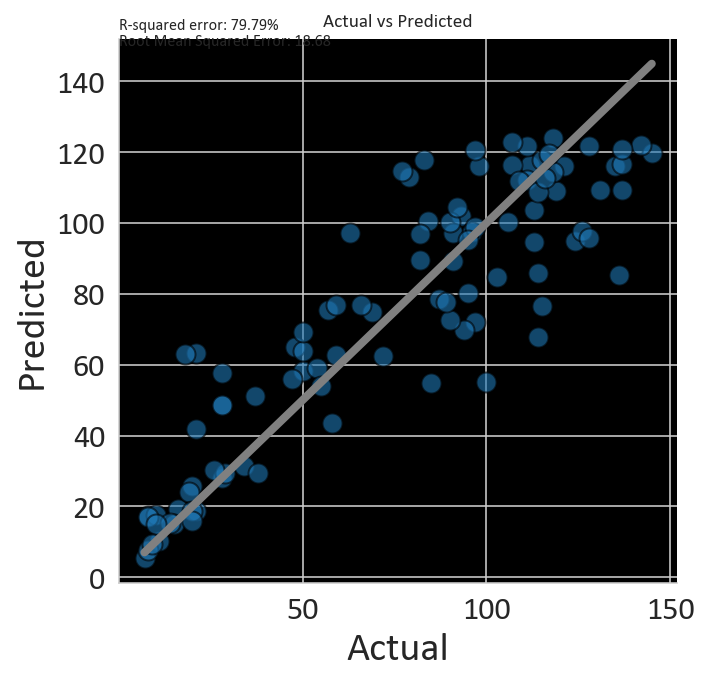

In [71]:

plt.rcParams['figure.figsize']=5,5 
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['legend.fontsize']=16

fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=y_test,
                y=y_predictions,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

plt.annotate(text=('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)) +'\n' +
                  'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False))),
             xy=(0,150),
             size='medium')

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

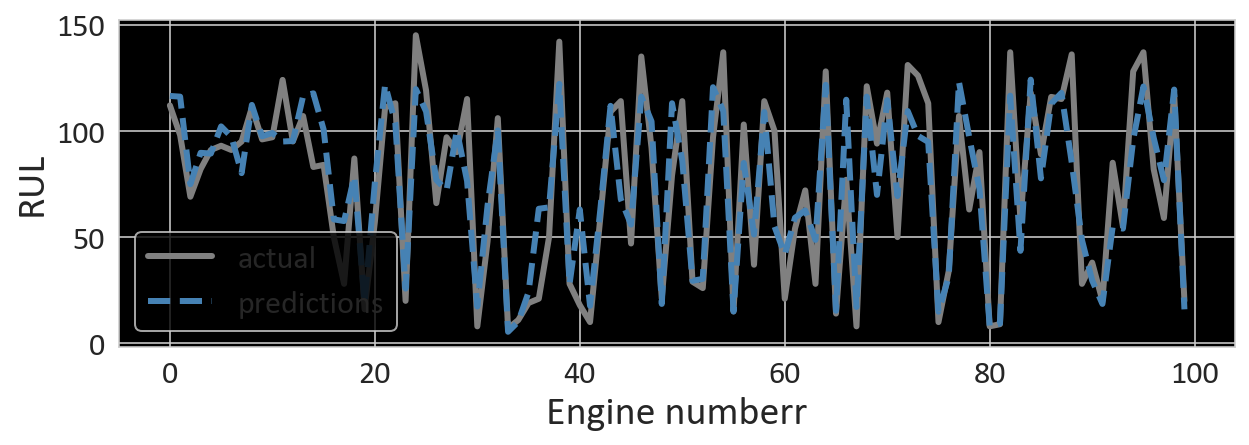

In [73]:
plt.rcParams['figure.figsize']=10,3 

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine numberr')

g = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_test,
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_predictions,
                color='steelblue',
                label = 'predictions',
                 linestyle='--',
                ax=ax)
ax.legend()

<a id='4_2'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>SVM</b>

In [74]:
%%time
from sklearn.svm import SVR
start = time.time()
model = SVR(kernel="rbf", C=100, gamma=0.5, epsilon=0.01).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

model_performance.loc['SVM'] = [model.score(X_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: 78.13%
Root Mean Squared Error: 19.43
CPU times: total: 8.66 s
Wall time: 34.6 s


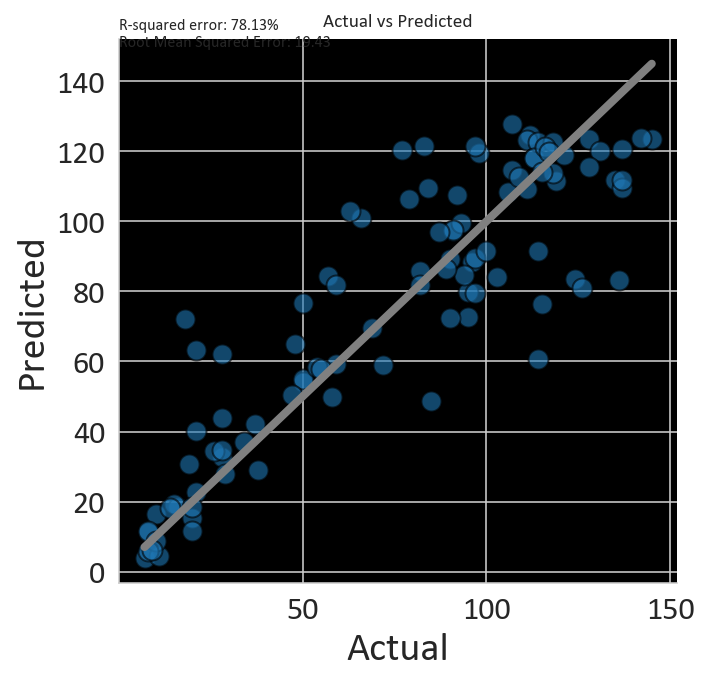

In [75]:
plt.rcParams['figure.figsize']=5,5 
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['legend.fontsize']=16

fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=y_test,
                y=y_predictions,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

plt.annotate(text=('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)) +'\n' +
                  'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False))),
             xy=(0,150),
             size='medium')

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

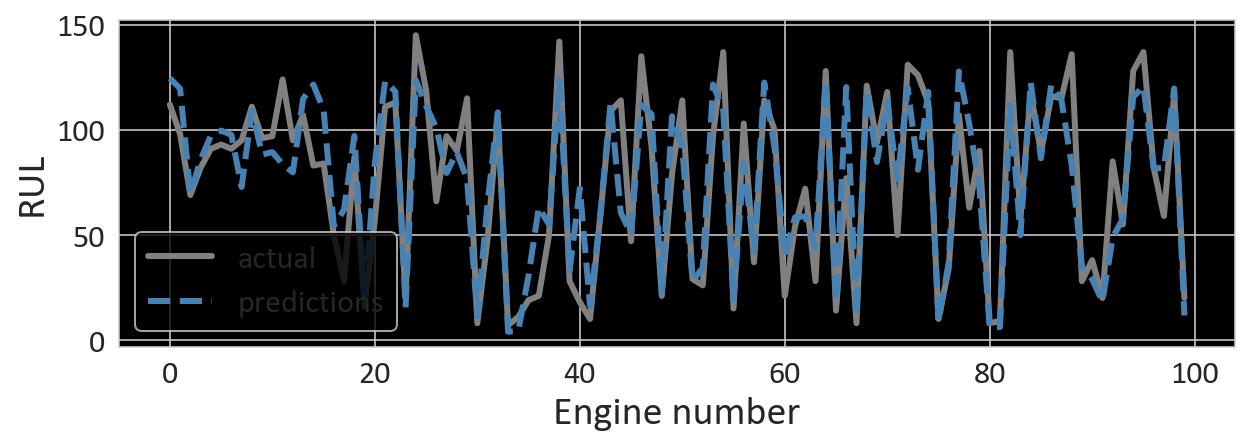

In [77]:
plt.rcParams['figure.figsize']=10,3 

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine number')

g = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_test,
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_predictions,
                color='steelblue',
                label = 'predictions',
                linestyle='--', 
                ax=ax)
ax.legend()

<a id='4_3'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>Random Forest</b>

In [78]:
%%time
from sklearn.ensemble import RandomForestRegressor
start = time.time()
model = RandomForestRegressor(n_jobs=-1,
                              n_estimators=500,
                              min_samples_leaf=1,
                              max_features='sqrt',
                             ).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

model_performance.loc['Random Forest'] = [model.score(X_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: 80.90%
Root Mean Squared Error: 18.16
CPU times: total: 1min
Wall time: 8.79 s


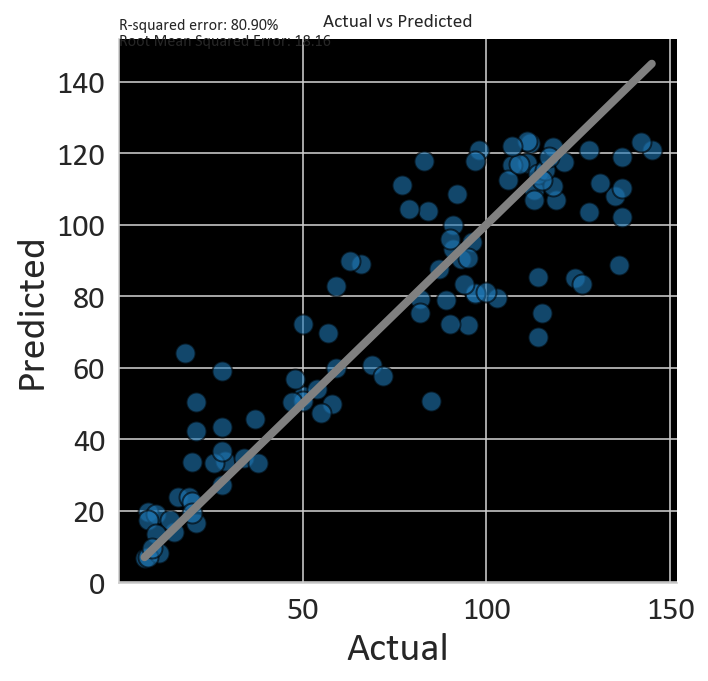

In [80]:
plt.rcParams['figure.figsize']=5,5 

fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=y_test,
                y=y_predictions,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

plt.annotate(text=('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)) +'\n' +
                  'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False))),
             xy=(0,150),
             size='medium')

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

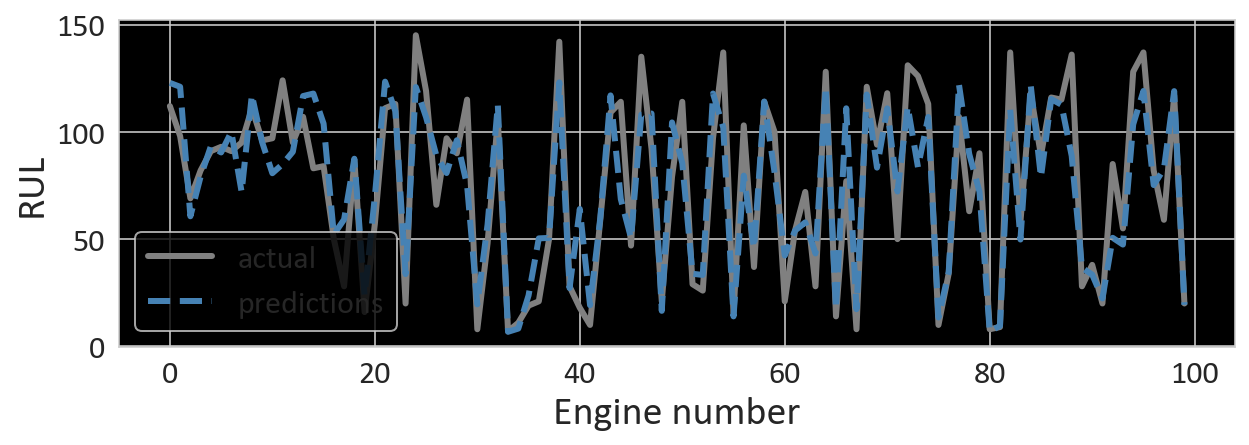

In [81]:
plt.rcParams['figure.figsize']=10,3 

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine number')

g = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_test,
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_predictions,
                color='steelblue',
                label = 'predictions',
                linestyle='--',
                ax=ax)
ax.legend()

<a id='4_4'></a>
## <p style="padding: 8px;color:white; display:fill;background-color:#aaaaaa; border-radius:5px; font-size:100%"> <b>LSTM+MSE and LSTM+UANLL</b>

LSTM (Long short term memory) through keras.

Initialization

In [82]:
num_epochs = 400
random_seeds = [42, 0, 17, 9, 3, 16, 2] # model seeds are used for deep ensembling
lr = 0.001  #learning rate
WD = 0.001 #weight decay (L2 regularization)
DO = 0.1 #dropout (at the trainig stage only)

In [83]:
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Model

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, BatchNormalization
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import sklearn
from sklearn.model_selection import train_test_split

Proposed loss

In [84]:
# Loss functions one can study here: Keras https://keras.io/api/losses/

# Proposed uncertainty-aware negative log-likelihood (UANLL) loss is an alternative to the MSE loss
class UANLLloss(Loss):
    def __init__(self, reduction='auto', *args, **kwargs):
        # Ensure reduction is set to a valid value
        if reduction == 'auto':
            reduction = 'sum'  # Default to 'sum' if 'auto' is provided
        super(UANLLloss, self).__init__(reduction=reduction, *args, **kwargs)

    def call(self, y_true, y_pred):
        # Ensure y_true and y_pred are cast to float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Split y_pred into mean and log variance
        mean_pred = y_pred[:,0,:]
        logvar_pred = y_pred[:,1,:]

        # Calculate the squared difference
        squared_difference = tf.square(y_true - mean_pred)

        # Calculate the loss
        loss = (tf.exp(-logvar_pred) * squared_difference + logvar_pred)
        mse_loss = tf.reduce_mean(loss)

        return mse_loss

Models

In [85]:
#Activatioin function by defauls is 'tanh'
#Proposed activation function
def sinOcos(x):
    return tf.sin(x) + tf.cos(x)

#Baseline LSTM model
def create_lstm_model(do=DO,af=sinOcos):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(1, X_train.shape[1])))
    model.add(BatchNormalization())
    model.add(LSTM(50, return_sequences=True, activation=af))
    model.add(Dropout(do))
    model.add(LSTM(10, return_sequences=True, activation=af))
    model.add(Dropout(do))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1))
    return model

#Proposed model based on UANLL loss requiers a network architecture with 2 outputs [mean, logarithmic variance]
def create_heteroscedastic_lstm_model(do=DO,af=sinOcos,input_shape=(1,X_train.shape[1])):
    inputs = Input(shape=input_shape)
    x = LSTM(100, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(50, return_sequences=True, activation=af)(x)
    x = Dropout(do)(x)
    x = LSTM(10, return_sequences=True, activation=af)(x)
    x = Dropout(do)(x)
    x = Dense(100, activation='relu')(x)
    mean_output = Dense(1, name='mean')(x)
    logvar_output = Dense(1, name='logvar')(x)
    outputs = tf.concat([mean_output, logvar_output], axis=1)
    model = Model(inputs=inputs, outputs=outputs)
    return model

Scheduler and early stop modules. The latter uses the checkpoint with min validation loss as the inference

In [86]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.96,
                              patience=10, min_lr=1e-7, verbose=1)

early_stop =keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=num_epochs,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
    # start_from_epoch=20,
)

Data

In [87]:
# Split the data
X_train_s, X_val, y_train_s, y_val = train_test_split(X_train, y_train, test_size=0.1)

# Reshape input data
#The LSTM input layer must be 3D.
#The meaning of the 3 input dimensions are: samples, time steps, and features.
#reshape input data
X_train_reshaped = X_train_s.reshape(X_train_s.shape[0], 1, X_train_s.shape[1])
X_val_reshaped = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [48]:
# model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
# modelUANLL.compile(loss = UANLLloss(), optimizer = tf.keras.optimizers.Adam(learning_rate=lr,decay=WD))

LSTM + MSE

In [88]:
num_epochs

400

In [90]:
# Train multiple models with different random seeds
models = []
start = time.time()
for seed in random_seeds:
    tf.random.set_seed(seed)
    model = create_lstm_model()
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=lr))
    history = model.fit(x=X_train_reshaped, y=y_train_s,
                        validation_data=(X_val_reshaped, y_val),
                        epochs=num_epochs,
                        batch_size=500,
                        callbacks=[reduce_lr, early_stop])
    models.append(model)
end_train = time.time()

Epoch 1/400
38/38 [==============================] - 10s 70ms/step - loss: 8857.6816 - val_loss: 8538.9287 - lr: 0.0010
Epoch 2/400
38/38 [==============================] - 1s 26ms/step - loss: 7596.5825 - val_loss: 6685.7314 - lr: 0.0010
Epoch 3/400
38/38 [==============================] - 1s 23ms/step - loss: 5490.1304 - val_loss: 4441.3843 - lr: 0.0010
Epoch 4/400
38/38 [==============================] - 1s 26ms/step - loss: 3410.7861 - val_loss: 2755.1289 - lr: 0.0010
Epoch 5/400
38/38 [==============================] - 1s 23ms/step - loss: 1891.3640 - val_loss: 1716.8529 - lr: 0.0010
Epoch 6/400
38/38 [==============================] - 1s 21ms/step - loss: 1004.6977 - val_loss: 1014.9737 - lr: 0.0010
Epoch 7/400
38/38 [==============================] - 1s 25ms/step - loss: 609.7923 - val_loss: 1132.8545 - lr: 0.0010
Epoch 8/400
38/38 [==============================] - 1s 26ms/step - loss: 453.9620 - val_loss: 1112.3088 - lr: 0.0010
Epoch 9/400
38/38 [==============================

In [91]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 1, 100)            46400     
                                                                 
 batch_normalization_7 (Bat  (None, 1, 100)            400       
 chNormalization)                                                
                                                                 
 lstm_22 (LSTM)              (None, 1, 50)             30200     
                                                                 
 dropout_14 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_23 (LSTM)              (None, 1, 10)             2440      
                                                                 
 dropout_15 (Dropout)        (None, 1, 10)             0         
                                                      

In [92]:
# Aggregate predictions from the models
y_predictions = np.zeros((X_test_reshaped.shape[0], len(models)))
for i, model in enumerate(models):
    y_predictions[:, i] = model.predict(X_test_reshaped).flatten()

# Compute the ensemble prediction
ensemble_prediction = np.mean(y_predictions, axis=1)
end_predict = time.time()

model_performance.loc['LSTM+MSE'] = [sklearn.metrics.r2_score(y_test, ensemble_prediction), 
                                   mean_squared_error(y_test,ensemble_prediction,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(sklearn.metrics.r2_score(y_test, ensemble_prediction)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,ensemble_prediction,squared=False)))

4/4 [==============================] - 1s 3ms/step
R-squared error: 72.61%
Root Mean Squared Error: 21.75


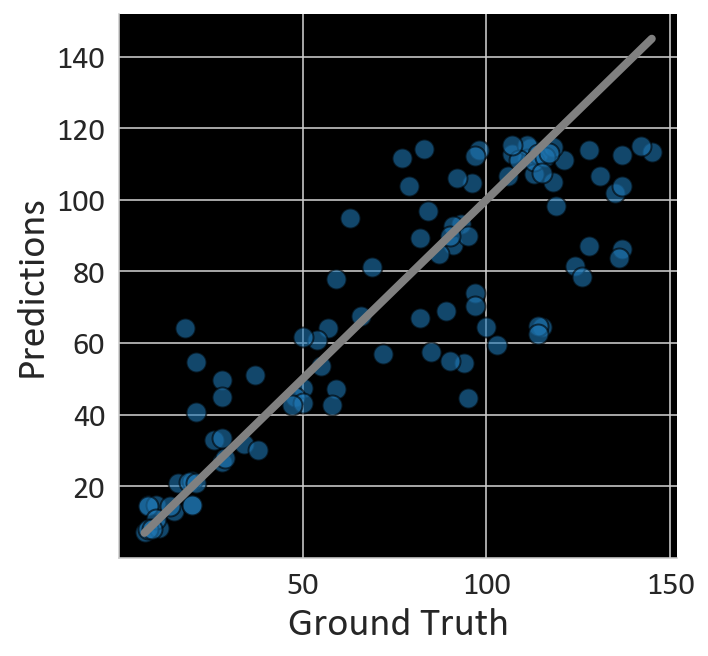

In [94]:
plt.rcParams['figure.figsize']=5,5 

fig,ax = plt.subplots()
# plt.title('Actual vs Predicted')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
g = sns.scatterplot(x=y_test,
                y=ensemble_prediction,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

# plt.annotate(text=('R-squared error: '+ "{:.2%}".format(sklearn.metrics.r2_score(y_test, ensemble_prediction)) +'\n' +
#                   'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,ensemble_prediction,squared=False))),
#              xy=(0,150),
#              size='large')

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

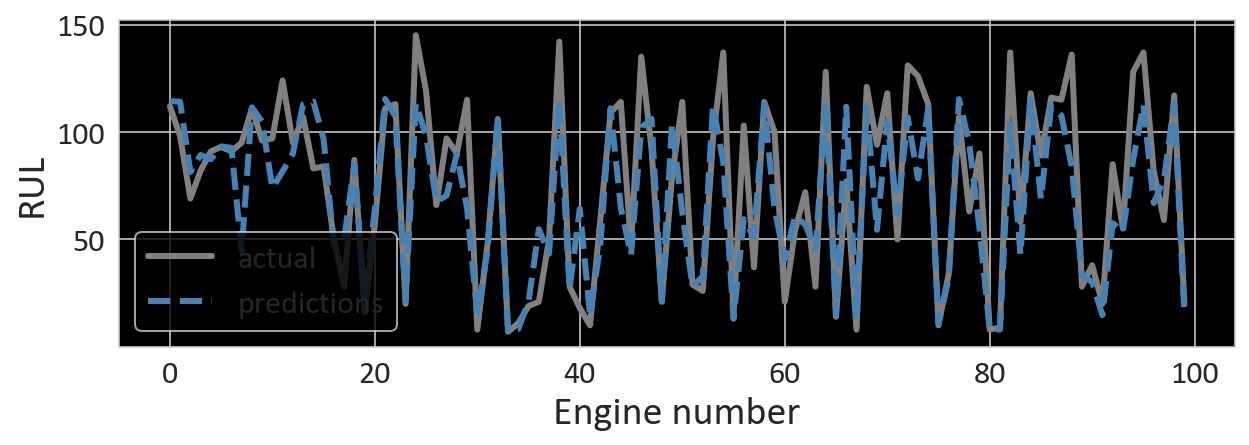

In [95]:
plt.rcParams['figure.figsize']=10,3 

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine number')

g = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_test,
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=ensemble_prediction,
                color='steelblue',
                label = 'predictions',
                linestyle='--',
                ax=ax)
ax.legend()


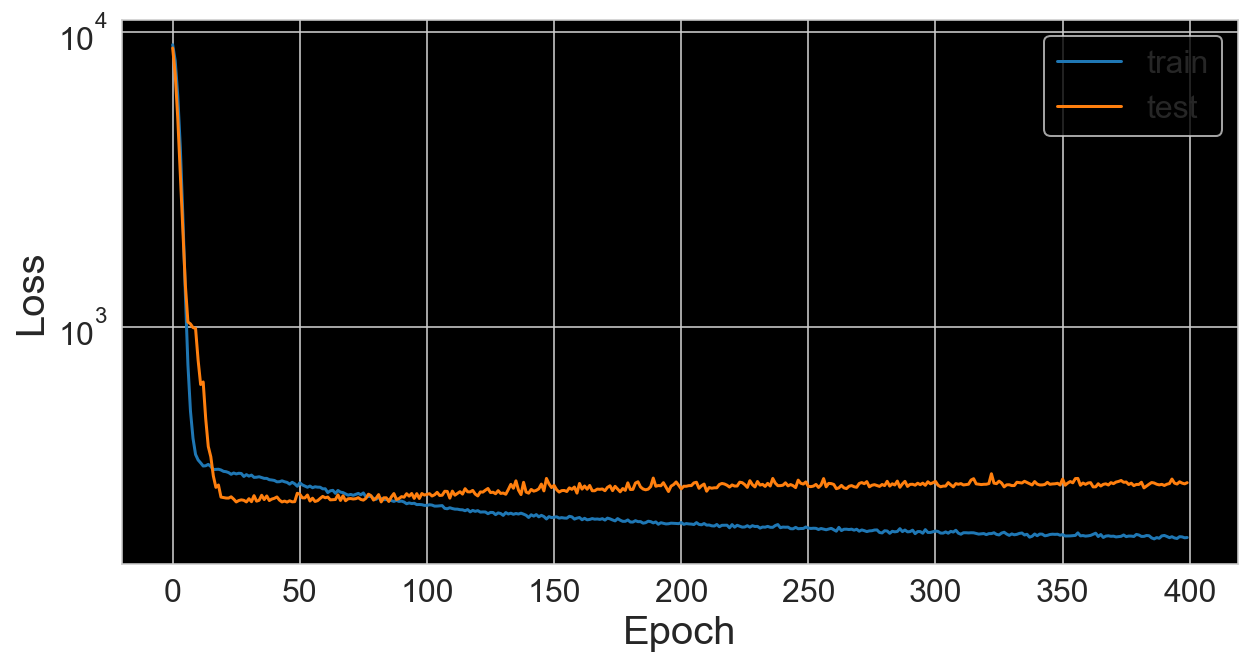

In [96]:
plt.rcParams['figure.figsize']=3,3 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 8
plt.rcParams['lines.linewidth'] = 1.5
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid('on')
plt.legend(['train', 'test'])
plt.show()

In [97]:
del[ensemble_prediction]
del[model]
del[history]

In [99]:
# Train multiple models with different random seeds
models = []
start = time.time()
for seed in random_seeds:
    tf.random.set_seed(seed)
    model = create_heteroscedastic_lstm_model()
    model.compile(loss = UANLLloss(), optimizer = tf.keras.optimizers.Adam(learning_rate=lr))
    history = model.fit(x=X_train_reshaped, y=y_train_s,
                        validation_data=(X_val_reshaped, y_val),
                        epochs=num_epochs,
                        batch_size=500,
                        callbacks=[reduce_lr, early_stop])
    models.append(model)
end_train = time.time()



Epoch 1/400
38/38 [==============================] - 13s 64ms/step - loss: 7933.7070 - val_loss: 2421.3469 - lr: 0.0010
Epoch 2/400
38/38 [==============================] - 1s 18ms/step - loss: 1089.8115 - val_loss: 337.5005 - lr: 0.0010
Epoch 3/400
38/38 [==============================] - 1s 18ms/step - loss: 206.5142 - val_loss: 101.9869 - lr: 0.0010
Epoch 4/400
38/38 [==============================] - 1s 17ms/step - loss: 82.8767 - val_loss: 52.1100 - lr: 0.0010
Epoch 5/400
38/38 [==============================] - 1s 19ms/step - loss: 49.0334 - val_loss: 33.2552 - lr: 0.0010
Epoch 6/400
38/38 [==============================] - 1s 17ms/step - loss: 33.7407 - val_loss: 24.1405 - lr: 0.0010
Epoch 7/400
38/38 [==============================] - 1s 18ms/step - loss: 26.2297 - val_loss: 19.0490 - lr: 0.0010
Epoch 8/400
38/38 [==============================] - 1s 19ms/step - loss: 21.4136 - val_loss: 15.9986 - lr: 0.0010
Epoch 9/400
38/38 [==============================] - 1s 18ms/step - lo

In [100]:
# Aggregate predictions from the models
y_predictions = np.zeros((X_test_reshaped.shape[0], len(models)))
y_logvar = np.zeros((X_test_reshaped.shape[0], len(models)))
for i, model in enumerate(models):
    y_predictions[:, i] = model.predict(X_test_reshaped)[:,0,0].flatten()
    y_logvar[:, i] = model.predict(X_test_reshaped)[:,1,0].flatten()
    
# Compute the ensemble prediction
ensemble_prediction = np.mean(y_predictions, axis=1)
ensemble_logvar = np.mean(y_logvar, axis=1)
end_predict = time.time()

model.summary()

4/4 [==============================] - 0s 6ms/step
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 1, 15)]              0         []                            
                                                                                                  
 lstm_45 (LSTM)              (None, 1, 100)               46400     ['input_8[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 1, 100)               400       ['lstm_45[0][0]']             
 tchNormalization)                                                                                
                                                                                                  
 lstm_46 (LSTM)              (None, 1, 50

In [101]:
# Aggregate predictions from the models
y_predictions = np.zeros((X_test_reshaped.shape[0], len(models)))
y_logvar = np.zeros((X_test_reshaped.shape[0], len(models)))
for i, model in enumerate(models):
    y_predictions[:, i] = model.predict(X_test_reshaped)[:,0,0].flatten()
    y_logvar[:, i] = model.predict(X_test_reshaped)[:,1,0].flatten()
    # y_predictions[:, i], y_logvar[:, i] = outputs[:,0,0], outputs[:,1,0] 

# Compute the ensemble prediction
ensemble_prediction = np.mean(y_predictions, axis=1)
ensemble_logvar = np.mean(y_logvar, axis=1)
end_predict = time.time()

model_performance.loc['LSTM+UANLL'] = [sklearn.metrics.r2_score(y_test, ensemble_prediction), 
                                   mean_squared_error(y_test,ensemble_prediction,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(sklearn.metrics.r2_score(y_test, ensemble_prediction)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,ensemble_prediction,squared=False)))

4/4 [==============================] - 0s 6ms/step
R-squared error: 78.21%
Root Mean Squared Error: 19.40


LSTM + UANLL

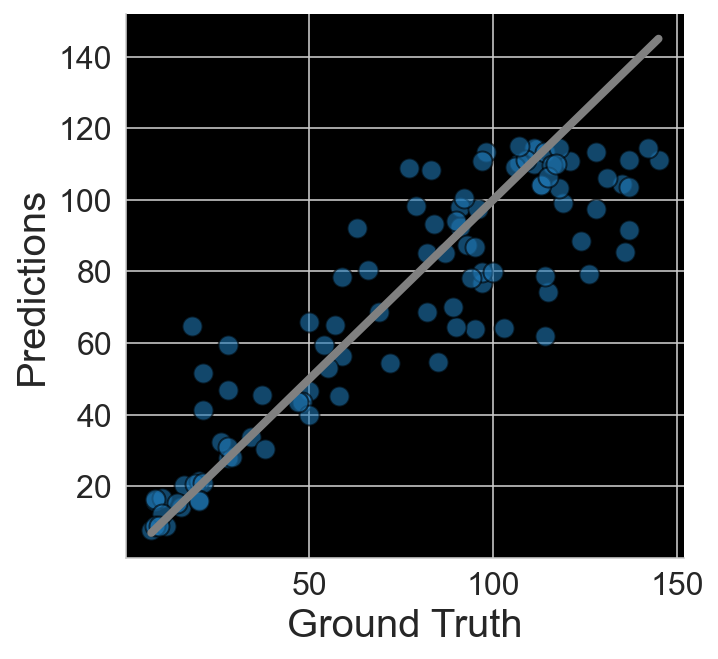

In [102]:
plt.rcParams['figure.figsize']=5,5 

fig,ax = plt.subplots()
# plt.title('Actual vs Predicted')
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
g = sns.scatterplot(x=y_test,
                y=ensemble_prediction,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

# plt.annotate(text=('R-squared error: '+ "{:.2%}".format(sklearn.metrics.r2_score(y_test, y_predictions)) +'\n' +
#                   'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False))),
#              xy=(0,150),
#              size='medium')

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

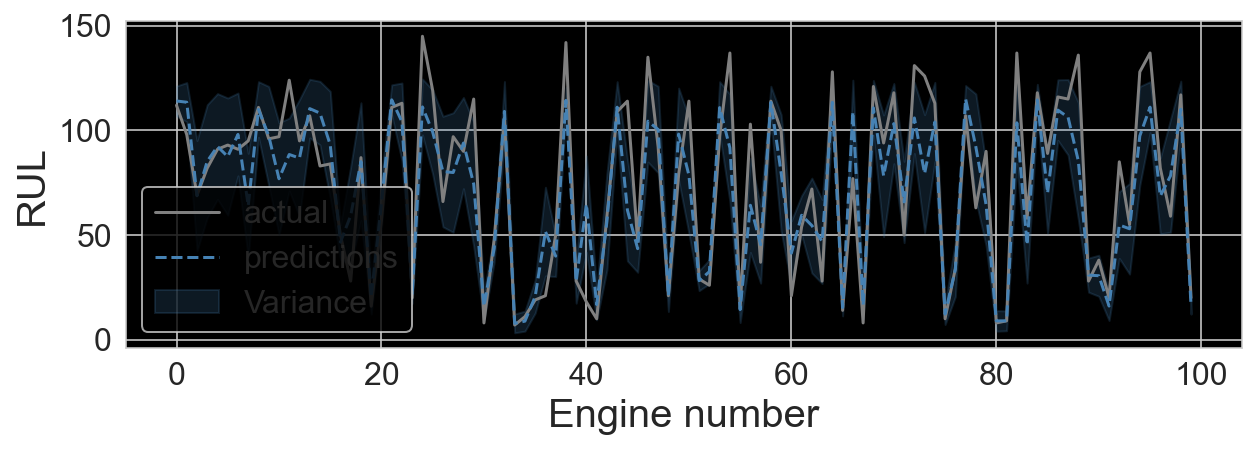

In [103]:
plt.rcParams['figure.figsize']=10,3 

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine number')

g = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_test,
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=ensemble_prediction,
                color='steelblue',
                label = 'predictions',
                linestyle='--',
                ax=ax)
# Calculate the upper and lower bounds for the variance
variances = tf.exp(ensemble_logvar)
lower_bounds = ensemble_prediction - np.sqrt(variances)
upper_bounds = ensemble_prediction + np.sqrt(variances)

# Fill the area between the upper and lower bounds
plt.fill_between(np.arange(0, len(df_train['engine'].unique())),
                 lower_bounds,
                 upper_bounds,
                 color='steelblue',
                 alpha=0.2,
                 label='Variance')

ax.legend()


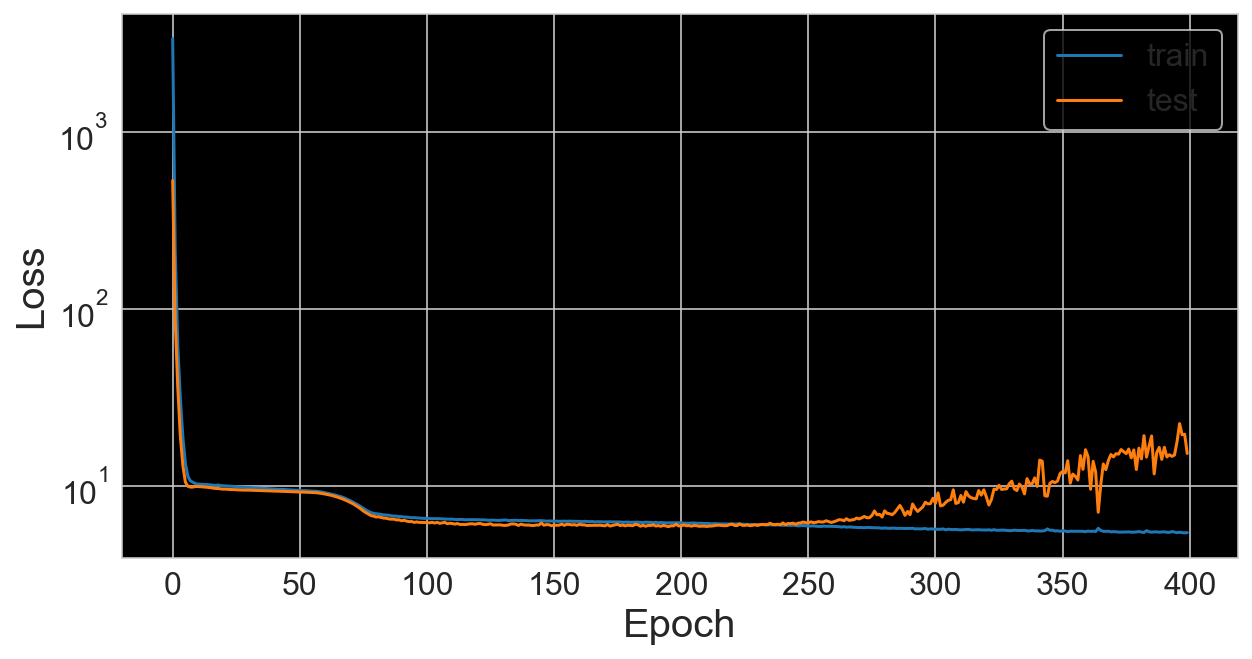

In [104]:
plt.rcParams['figure.figsize']=3,3 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 8
plt.rcParams['lines.linewidth'] = 1.5
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid('on')
plt.legend(['train', 'test'])
plt.show()

<a id='5'></a>
# <p style="padding: 8px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:100%"> <b>Evaluate</b>

In [105]:
model_performance.style.background_gradient(cmap='RdYlBu_r').format({'R2': '{:.2%}',
                                                                     'RMSE': '{:.2f}',
                                                                     'time to train':'{:.3f}',
                                                                     'time to predict':'{:.3f}',
                                                                     'total time':'{:.3f}',
                                                                     })